In [41]:
import nltk
import math
import joblib
from collections import defaultdict
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')
from nltk.corpus import brown

[nltk_data] Downloading package brown to /home/parth/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/parth/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [72]:
Vocab = len(set([str(k[0]).lower() for k in brown.tagged_words()]))

In [75]:
START_DELIM = '^'
LOW_PROB = 1e-10

In [4]:
tagged_sentences = brown.tagged_sents(tagset='universal')
all_tags = list(set([tag for sentence in tagged_sentences for _, tag in sentence]))

In [112]:
class HiddenMarkovModel:

    def __init__(self, sentences = [], k_smoothing = 0):
        self.sentences = sentences
        self._find_tags()
        self.k_smoothing = k_smoothing
        self.compute_transition_probabilities()
        self.compute_emmision_probabilities()
    
    def _find_tags(self):
        self.tags = list(set( [ word_tag[1] for sentence in tagged_sentences for word_tag in sentence ] ))
    
    def compute_transition_probabilities(self):
        T = defaultdict(lambda: defaultdict(lambda:0))
        # T = dict of dicts
        # T[tcurr] = dict
        # T[tcurr][tprev] = integer with default value as 0
        TC = defaultdict(lambda : 1)
        # TC (tag count) = dict
        # TC[tag] = integer with default value as 0
        
        for sentence in self.sentences:
            # skip first word for now
            prev_word = (START_DELIM, START_DELIM)
            for word in sentence:
                T[word[1]][prev_word[1]] += 1
                TC[word[1]] += 1
                prev_word = word
        
        TC[START_DELIM] = len(self.sentences)

        for curr_tag in T:
            for prev_tag in T[curr_tag]:
                if curr_tag in T and prev_tag in T[curr_tag]:
                    T[curr_tag][prev_tag] = T[curr_tag][prev_tag] / TC[prev_tag]
        
        self.T = T
        self.TC = TC
    
    def compute_emmision_probabilities(self):
        E = defaultdict(lambda: defaultdict(lambda:self.k_smoothing))
        # W = dict of dicts
        # W[word] = dict
        # W[word][tag] = integet with default value as 0        

        for sentence in self.sentences:
            for word in sentence:
                E[word[0]][word[1]] += 1

        for word in E.keys():
            for tag in E[word].keys():
                E[word][tag] = E[word][tag] / (self.TC[tag] + (Vocab * self.k_smoothing))

        self.E = E

    def word_given_tag(self, word, tag):
        if word in self.E and tag in self.E[word]:
            return self.E[word][tag]
        else:
            if self.k_smoothing == 0:
                return LOW_PROB
            else:
                return (self.k_smoothing / (self.TC[tag] + Vocab))
        

    def trans(self, curr_tag, prev_tag):
        if curr_tag in self.T:
            return self.T[curr_tag].get(prev_tag , LOW_PROB)
        else:
            return LOW_PROB
            
            


In [156]:
class POSTaggerModel:
    def __init__(self, sentences, k_smoothing=0):
        self.sentences = sentences
        self.k_smoothing = k_smoothing
        self.hmm = None
        
    def Viterbi(self, words):
        selected_path_and_probs = [{ START_DELIM : (START_DELIM , 0) }]
        # tag : ( best_prev_tag , best_prob_if_word_has_this_tag )
        
        
        curr_state_probabilities = {}
        for tag in all_tags:
            # any tag can be placed for the first word w1
            curr_state_probabilities[tag] = ('^', math.log(self.hmm.trans(tag,'^',)) + math.log(self.hmm.word_given_tag(words[0],tag)))
            
        selected_path_and_probs.append(curr_state_probabilities)
        
        for word in words[1:]:
            curr_state_probabilities = {}
            for curr_tag in all_tags:
                curr_max = None
                for prev_tag , best_till_prev in selected_path_and_probs[-1].items():
                    possible_state_prob = best_till_prev[1] + math.log(self.hmm.trans(curr_tag,prev_tag)) + math.log(self.hmm.word_given_tag(word,curr_tag))
                    if not curr_max or possible_state_prob > curr_max:
                        curr_state_probabilities[curr_tag] = (prev_tag , possible_state_prob)
                        curr_max = possible_state_prob
                        
            selected_path_and_probs.append(curr_state_probabilities)
        
        
        max_prob = max([ d[1] for d in selected_path_and_probs[-1].values()])
        last_tag = None
        
        for tag in selected_path_and_probs[-1].keys():
            if selected_path_and_probs[-1][tag][1] == max_prob:
                last_tag = tag
        
        rev_tag_seq = [last_tag]
    
        for i in range(len(words)-1):
            ind = -1*(i + 1)
            last_tag = selected_path_and_probs[ind][last_tag][0]
            rev_tag_seq.append(last_tag)
    
        
        return [w for w in reversed(rev_tag_seq)]

    def fit(self):
        self.hmm = HiddenMarkovModel(self.sentences, k_smoothing = self.k_smoothing)

    def predict(self,sentence):
        words = [word[0] for word in sentence]
        return self.Viterbi(words)
        


In [114]:
NUM_FOLDS = 5
kf = KFold(NUM_FOLDS , shuffle=  True, random_state=42)

accuracies = []
all_true_tags = []
all_predicted_tags = []

iteration = 1
for train_indices, test_indices in kf.split(tagged_sentences):
    train_data = [tagged_sentences[i] for i in train_indices]
    test_data = [tagged_sentences[i] for i in test_indices]

    model = POSTaggerModel(train_data, k_smoothing=0)
    model.fit()
    
    true_tags = []
    predicted_tags = []
    
    for sentence in test_data:
        true_tags += [word[1] for word in sentence]
        predicted_tags += model.predict(sentence)
    
    all_true_tags += true_tags
    all_predicted_tags += predicted_tags

    curr_model_accuracy = accuracy_score(true_tags, predicted_tags)
    
    accuracies.append(curr_model_accuracy)

    print(f"Accuracy for Model-{iteration} : {curr_model_accuracy}")
    iteration += 1

overall_accuracy = np.mean(accuracies)

print(f"Overall(Mean) Accuracy (5-Fold Cross-Validation): {overall_accuracy:.4f}")
print(f"Standard Deviation of Model Accuracy (5-Fold Cross-Validation): {overall_accuracy:.4f}")

print("Classification Statistics : ")
"""
F1-score is basically F-score with equal weightage to both precision and recall
i.e. Beta Square is 1
"""

print(classification_report(y_true=all_true_tags, y_pred=all_predicted_tags, labels=all_tags))


Accuracy for Model-1 : 0.9566587762528727
Accuracy for Model-2 : 0.9569540846441851
Accuracy for Model-3 : 0.9567955350322894
Accuracy for Model-4 : 0.9564043495490631
Accuracy for Model-5 : 0.9565653796680935
Overall(Mean) Accuracy (5-Fold Cross-Validation): 0.9567
Standard Deviation of Model Accuracy (5-Fold Cross-Validation): 0.9567
Classification Statistics : 
              precision    recall  f1-score   support

        NOUN       0.96      0.95      0.95    275558
        VERB       0.97      0.94      0.96    182750
         ADJ       0.91      0.91      0.91     83721
        PRON       0.95      0.98      0.97     49334
           .       1.00      1.00      1.00    147565
         DET       0.95      0.99      0.97    137019
        CONJ       0.99      1.00      0.99     38151
         ADP       0.95      0.97      0.96    144766
         NUM       0.97      0.91      0.94     14874
           X       0.80      0.49      0.61      1386
         PRT       0.91      0.91     

Text(133.22222222222223, 0.5, 'True Tags')

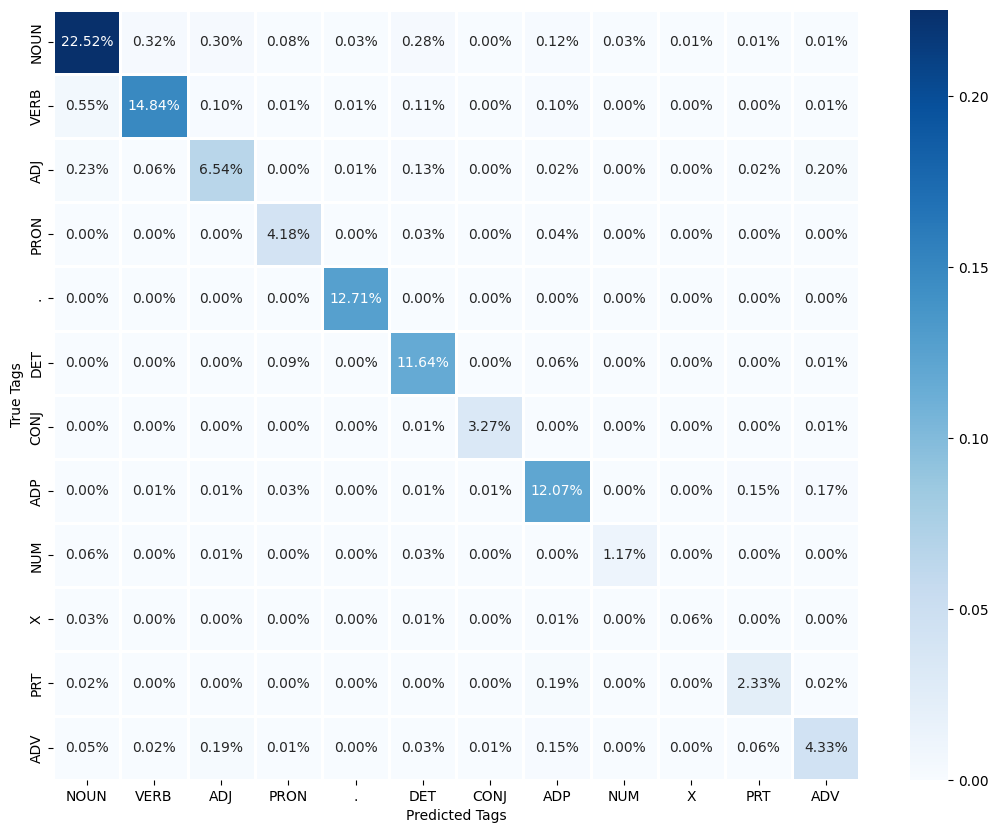

In [122]:
cf_matrix = confusion_matrix(all_true_tags, all_predicted_tags, labels=all_tags)
fig, ax = plt.subplots(figsize=(13,10))     
sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, linewidths=1, ax=ax, cmap='Blues', xticklabels=all_tags, yticklabels=all_tags)
ax.set_xlabel("Predicted Tags")
ax.set_ylabel("True Tags")

Text(0, 0.5, 'Accuracy %')

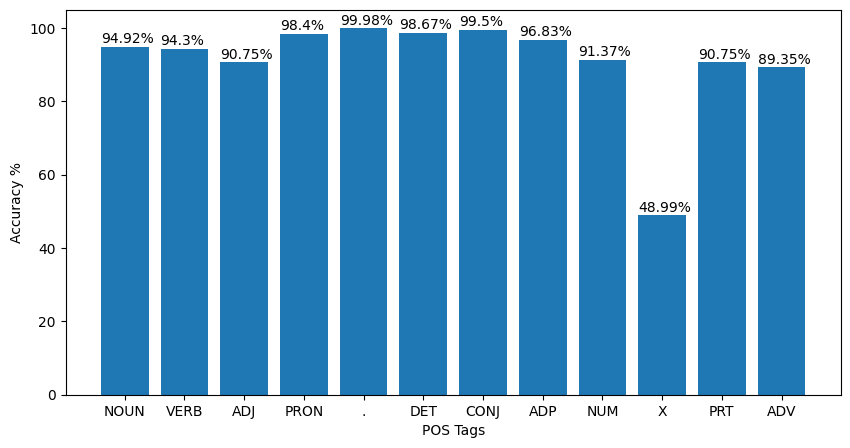

In [153]:
get_count_of_tags = lambda tag: len()
per_tag_accuracy = [ round((cf_matrix[i][i] / np.sum(cf_matrix[i]))*100,2) for i in range(len(model.hmm.tags)) ]
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(model.hmm.tags , per_tag_accuracy, label=model.hmm.tags)
for i in range(len(model.hmm.tags)):
    ax.text(i-0.4, per_tag_accuracy[i]+1, f"{per_tag_accuracy[i]}%")
ax.set_xlabel("POS Tags")
ax.set_ylabel("Accuracy %")

In [158]:
# Final model to export 
# Train on the entire dataset
print("Training Final POS Model...")
model = POSTaggerModel(list(tagged_sentences))
print("Saving Model...", end ='')
joblib.dump(model, "pos-tagger.pkl")
print("Saved !")

Training Final POS Model...
Saving Model...Saved !


In [8]:
tags_seq = Viterbi("The boat was sailing in the pacific ocean".split(" "),hmm)
print(' '.join(tags_seq))

DET NOUN VERB VERB ADP DET ADJ NOUN
